Simulation

In [3]:
# Import packages
import random
import math
import matplotlib
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib.dates as mdates
from torch.autograd import Variable
import time as ti
import sklearn.metrics as sk
from dateutil.relativedelta import relativedelta
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm.notebook import trange, tqdm

device0 = torch.device('cuda' if torch.cuda.is_available else 'cpu')
np.random.seed(16)
torch.manual_seed(16)
torch.cuda.manual_seed(16) 
torch.set_default_dtype(torch.float32)

In [4]:
config = {
    "font.family": 'sans-serif',
    "font.sans-serif": ['Arial'],
    "font.size": 15,
    "mathtext.fontset": 'stixsans',
}
plt.rcParams.update(config)

In [5]:
H=1+math.ceil(np.log2((np.sqrt(2500)-1)/9))
n = 50 
N = int(n**2) ## sample size
M = 1 ## Number of replicate
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
P = 1
X = np.array([np.ones(N)]).T
s1,s2 = np.meshgrid(x,y)
s = np.vstack((s1.flatten(),s2.flatten())).T
beta0_true =2+np.sin(30*((s[:,0]+s[:,1])/2-0.9)**4)*np.cos(2*((s[:,0]+s[:,1])/2-0.9))+((s[:,0]+s[:,1])/2-0.9)/2

In [6]:
num_basis = [10**2,19**2,37**2,73**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]
joblib.dump(phi,'Wendland')

['Wendland']

In [7]:
#Gaussian kernel
num_basis = [10**2,19**2,37**2,73**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            phi[j,i + K] = np.exp(-d[j]**2)
    K = K + num_basis[res]
joblib.dump(phi,'Gaussian')

['Gaussian']

In [6]:
# load data
X_spt=joblib.load('X_cov')
Z=joblib.load('data_nonstationary')
phi_w=joblib.load('Wendland')
phi_g=joblib.load('Gaussian')
phi_w=torch.tensor(phi_w).float().cuda()
phi_g=torch.tensor(phi_g).float().cuda()
X_spt=X_spt.float().cuda()
X_spt_w=torch.cat((X_spt,phi_w),1)
X_spt_g=torch.cat((X_spt,phi_g),1)
Z=Z.float().cuda()
T=1095
S=2500
Z.shape

torch.Size([2500, 1095])

In [7]:
# split data
random.seed(16)
idx=[i for i in range(2500)]
train_idx=random.sample(idx,2000)
tmp1=set(idx).difference(set(train_idx))
valid_idx=random.sample(tmp1,250)
tmp2=set(tmp1).difference(set(valid_idx))
test_idx=random.sample(tmp2,250)

C:\Users\13219\AppData\Local\Temp\ipykernel_77196\546523093.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  valid_idx=random.sample(tmp1,250)
C:\Users\13219\AppData\Local\Temp\ipykernel_77196\546523093.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_idx=random.sample(tmp2,250)


In [9]:
# DSVCM
class Net(nn.Module): 
    def __init__(self,dim_output, dim_input=7159, dim_emb=128,dim_linear=128, dropout_input=0.5, dropout_emb=0.5, 
                 dropout_context=0.5,  l2=0.0001, batch_first=True):
        super(Net,self).__init__()
        self.batch_first = batch_first


        self.embedding = nn.Sequential(
            nn.Dropout(p=dropout_input),
            nn.Linear(dim_input, dim_emb, bias=False),
            nn.Dropout(p=dropout_emb)
        )
        init.xavier_normal_(self.embedding[1].weight)
        
        
        self.input = nn.Linear(dim_emb,dim_linear,bias=True)
        init.xavier_normal_(self.input.weight)
        self.input.bias.data.zero_()
        
        self.hidden1 = nn.Linear(dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden1.weight)
        self.hidden1.bias.data.zero_()
        
        self.hidden2 = nn.Linear(dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden2.weight)
        self.hidden2.bias.data.zero_()
        
        self.hidden3 = nn.Linear(dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden3.weight)
        self.hidden3.bias.data.zero_()
        
        self.outputdnn = nn.Linear(dim_linear,dim_emb,bias=True)
        init.xavier_normal_(self.outputdnn.weight)
        self.outputdnn.bias.data.zero_()
        
        self.attention = nn.Linear(dim_emb,dim_emb,bias=True)
        init.xavier_normal_(self.attention.weight, gain=nn.init.calculate_gain('tanh'))
        self.attention.bias.data.zero_()
        
        
        self.output = nn.Sequential(
            nn.Dropout(p=dropout_context),
            nn.Linear(in_features=dim_emb, out_features=dim_output)
        )
        init.xavier_normal_(self.output[1].weight)
        self.output[1].bias.data.zero_()
        
        self.input2 = nn.Linear(dim_emb,dim_linear,bias=True)
        init.xavier_normal_(self.input2.weight)
        self.input2.bias.data.zero_()

        self.hidden4 = nn.Linear(dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden4.weight)
        self.hidden4.bias.data.zero_()

        self.hidden5 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden4.weight)
        self.hidden4.bias.data.zero_()
        
        self.hidden6 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden6.weight)
        self.hidden6.bias.data.zero_()
        
        self.hidden7 = nn.Linear(2*dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden7.weight)
        self.hidden7.bias.data.zero_()
        
        self.outputcoef = nn.Linear(dim_linear,11,bias=True)
        init.xavier_normal_(self.outputcoef.weight)
        self.outputcoef.bias.data.zero_()

    def forward(self,x):
        
        emb = self.embedding(x[:,11:])
        
        input_cov = self.input2(emb)
        input_cov = F.relu(input_cov)

        input4 = self.hidden4(input_cov)
        input4 = F.relu(input4)

        input5 = self.hidden5(input4)
        input5 = F.relu(input4)
        
        input6 = self.hidden6(input5)
        input6 = F.relu(input6)
        
        input7 = self.hidden7(input6)
        input7 = F.relu(input7)
        
        output_coef=self.outputcoef(input7)
        
        intercept = output_coef*x[:,:11]
        
        intercept = torch.sum(intercept,1,keepdim=True)


        finaltemp =  intercept+ spatial_mean 

        return finaltemp,output_coef

In [10]:
net = Net(dim_output=1).cuda()
print(net)

Net(
  (embedding): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=7159, out_features=128, bias=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (input): Linear(in_features=128, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=128, bias=True)
  (outputdnn): Linear(in_features=128, out_features=128, bias=True)
  (attention): Linear(in_features=128, out_features=128, bias=True)
  (output): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (input2): Linear(in_features=128, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=256, bias=True)
  (hidden5): Linear(in_features=256, out_features=256, bias=True)
  (hidden6): Linear(in_features=256, out_features=256, bias=True)
  (hidden7): Linear(in_features=25

In [11]:
train_set = Data.TensorDataset(X_spt_w[train_idx],Z[train_idx])
train_loader=Data.DataLoader(dataset=train_set, batch_size=2000,shuffle=False)


valid_set = Data.TensorDataset(X_spt_w[valid_idx],Z[valid_idx])
valid_loader=Data.DataLoader(dataset=valid_set, batch_size=250,shuffle=False)


test_set = Data.TensorDataset(X_spt_w[test_idx],Z[test_idx])
test_loader =Data.DataLoader(dataset=test_set, batch_size=250,shuffle=False)


In [12]:
train_dataset=Z[train_idx]
spatial_mean=torch.mean(train_dataset,0,True)
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
# optimizer = torch.optim.SGD(net.parameters(),lr =0.0001,momentum=0.9,nesterov=True)
loss_func = torch.nn.MSELoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8000, eta_min=0, last_epoch=- 1, verbose=False)

def epoch(loader,train=False):
    if train:
        net.train()
        mode = 'Train'
    else:
        net.eval()
        mode = 'Eval'
    
    true_value = []
    outputs = []
    attention =[]
    output_coefs = []
    losses = 0

    for step ,(batch_x,batch_z) in enumerate(loader):
        input_var=Variable(batch_x)
        target_var=Variable(batch_z)
    
        prediction,output_coef= net(input_var)
        loss = loss_func(prediction,target_var)
        
        outputs.append(prediction.data)
        output_coefs.append(output_coef.data)
        losses=losses+loss.data
    
        # compute gradient and do update step
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return torch.cat(outputs, 0),torch.cat(output_coefs,0),losses/len(loader)

In [13]:
# main
best_valid_epoch = 0
best_valid_loss = 1e10


train_losses = []
valid_losses = []
n_epochs=8000

time_start=ti.time()

for ei in trange(n_epochs):
            

    
    train_y_pred,  train_coef, train_loss = epoch(train_loader,train=True)

    train_losses.append(train_loss)

# Eval
    valid_y_pred, valid_coef, valid_loss = epoch(valid_loader)
    valid_losses.append(valid_loss)

    valid_y_pred = valid_y_pred.cpu()


    is_best = valid_loss < best_valid_loss

    if is_best:
        best_valid_epoch = ei
        best_valid_loss = valid_loss

    # evaluate on the test set
        test_y_pred, test_coef, test_loss = epoch(test_loader)
        
        train_coef_best = train_coef
        train_y_pred_best = train_y_pred.cpu()
        test_y_pred = test_y_pred.cpu()
        
        
        with open('DSVCM_Wendlend.txt', 'w') as f:
            f.write('Best Validation Epoch: {}\n'.format(ei))
            f.write('Best Validation Loss: {}\n'.format(best_valid_loss))
            f.write('Train Loss: {}\n'.format(train_loss))
            f.write('Test Loss: {}\n'.format(test_loss))

   
        torch.save(net,'DSVCM_Wendlend.pt')
    
    scheduler.step()

time_end=ti.time()
print(best_valid_loss)
print('Run Time (s):' ,time_end-time_start)
print((time_end-time_start)/n_epochs)

  0%|          | 0/8000 [00:00<?, ?it/s]

tensor(0.0069, device='cuda:0')
Run Time (s): 161.10382556915283
0.020137978196144105


In [40]:
torch.cuda.empty_cache()

In [41]:
train_set = Data.TensorDataset(X_spt_g[train_idx],Z[train_idx])
train_loader=Data.DataLoader(dataset=train_set, batch_size=2000,shuffle=False)


valid_set = Data.TensorDataset(X_spt_g[valid_idx],Z[valid_idx])
valid_loader=Data.DataLoader(dataset=valid_set, batch_size=250,shuffle=False)


test_set = Data.TensorDataset(X_spt_g[test_idx],Z[test_idx])
test_loader =Data.DataLoader(dataset=test_set, batch_size=250,shuffle=False)

In [42]:
# main
best_valid_epoch = 0
best_valid_loss = 1e10


train_losses = []
valid_losses = []
n_epochs=8000

time_start=ti.time()

for ei in trange(n_epochs):
            

    
    train_y_pred,  train_coef, train_loss = epoch(train_loader,train=True)

    train_losses.append(train_loss)

# Eval
    valid_y_pred, valid_coef, valid_loss = epoch(valid_loader)
    valid_losses.append(valid_loss)

    valid_y_pred = valid_y_pred.cpu()


    is_best = valid_loss < best_valid_loss

    if is_best:
        best_valid_epoch = ei
        best_valid_loss = valid_loss

    # evaluate on the test set
        test_y_pred, test_coef, test_loss = epoch(test_loader)
        
        train_coef_best = train_coef
        train_y_pred_best = train_y_pred.cpu()
        test_y_pred = test_y_pred.cpu()
        
        
        with open('DSVCM_Gaussian.txt', 'w') as f:
            f.write('Best Validation Epoch: {}\n'.format(ei))
            f.write('Best Validation Loss: {}\n'.format(best_valid_loss))
            f.write('Train Loss: {}\n'.format(train_loss))
            f.write('Test Loss: {}\n'.format(test_loss))

   
        torch.save(net,'DSVCM_Gaussian.pt')
    
    scheduler.step()

time_end=ti.time()
print(best_valid_loss)
print('Run Time (s):' ,time_end-time_start)
print((time_end-time_start)/n_epochs)

  0%|          | 0/8000 [00:00<?, ?it/s]

tensor(0.0067, device='cuda:0')
Run Time (s): 155.87981605529785
0.019484977006912232


In [14]:
bestmodel_w=torch.load('DSVCM_Wendlend.pt')
bestmodel_g=torch.load('DSVCM_Gaussian.pt')
print(bestmodel_g)

Net(
  (embedding): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=7159, out_features=128, bias=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (input): Linear(in_features=128, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=128, bias=True)
  (outputdnn): Linear(in_features=128, out_features=128, bias=True)
  (attention): Linear(in_features=128, out_features=128, bias=True)
  (output): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (input2): Linear(in_features=128, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=256, bias=True)
  (hidden5): Linear(in_features=256, out_features=256, bias=True)
  (hidden6): Linear(in_features=256, out_features=256, bias=True)
  (hidden7): Linear(in_features=25

In [15]:
pred_data_w,coef_w=bestmodel_w(X_spt_w)
pred_data_g,coef_g=bestmodel_g(X_spt_g)

# Wendland Kernel
coef_w[:,1:]=coef_w[:,1:]*X_spt_w[:,1:11]
coef_w=coef_w.detach().cpu().numpy()
beta_w=coef_w[:,0]
for i in range(2500):
    if beta_w[i]<1.35:
        beta_w[i]=1.35

# Gaussian Kernel
coef_g[:,1:]=coef_g[:,1:]*X_spt_g[:,1:11]
coef_g=coef_g.detach().cpu().numpy()
beta_g=coef_g[:,0]
for i in range(2500):
    if beta_g[i]<1.35:
        beta_g[i]=1.35

In [16]:
n=len(train_set)
decay=0.0001
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            
def uncertainity_estimate_s(x,z, model, num_samples, l2,t):
    model.eval()
    enable_dropout(model)
    outputs=np.stack([model(x)[0].cpu().detach().numpy() for _ in range(num_samples)])
    Z_mean=outputs[:,:,t].mean(axis=0)
    Z_variance=outputs[:,:,t].var(axis=0)
    # tau = np.square(l2) * (1. - 0.5) / (2. * n *decay )
    # use emprical variance to estimate the error variance
    tau=(z[:,t].cpu().numpy()-Z_mean)**2- Z_variance
    tau[tau<0]=0
    # print(tau)
    Z_variance += np.mean(tau)
    Z_std = np.sqrt(Z_variance)
    return Z_mean, Z_std

Z_mean_w,Z_std_w = uncertainity_estimate_s(X_spt_w,Z,bestmodel_w,1000,1,487)
Z_mean_g,Z_std_g = uncertainity_estimate_s(X_spt_g,Z,bestmodel_g,1000,1,487)
# Z_var=np.square(Z_std)
print('Stanard Error:',Z_std_w)
print('Stanard Error:',Z_std_g)
print('Mean:',Z_mean_g)

Stanard Error: [0.08221325 0.08211883 0.08429425 ... 0.0830595  0.08143972 0.08265977]
Stanard Error: [0.08247259 0.08197037 0.08450703 ... 0.08262039 0.08138876 0.08206126]
Mean: [24.292978 26.04128  26.614002 ... 26.101181 26.0537   25.657131]


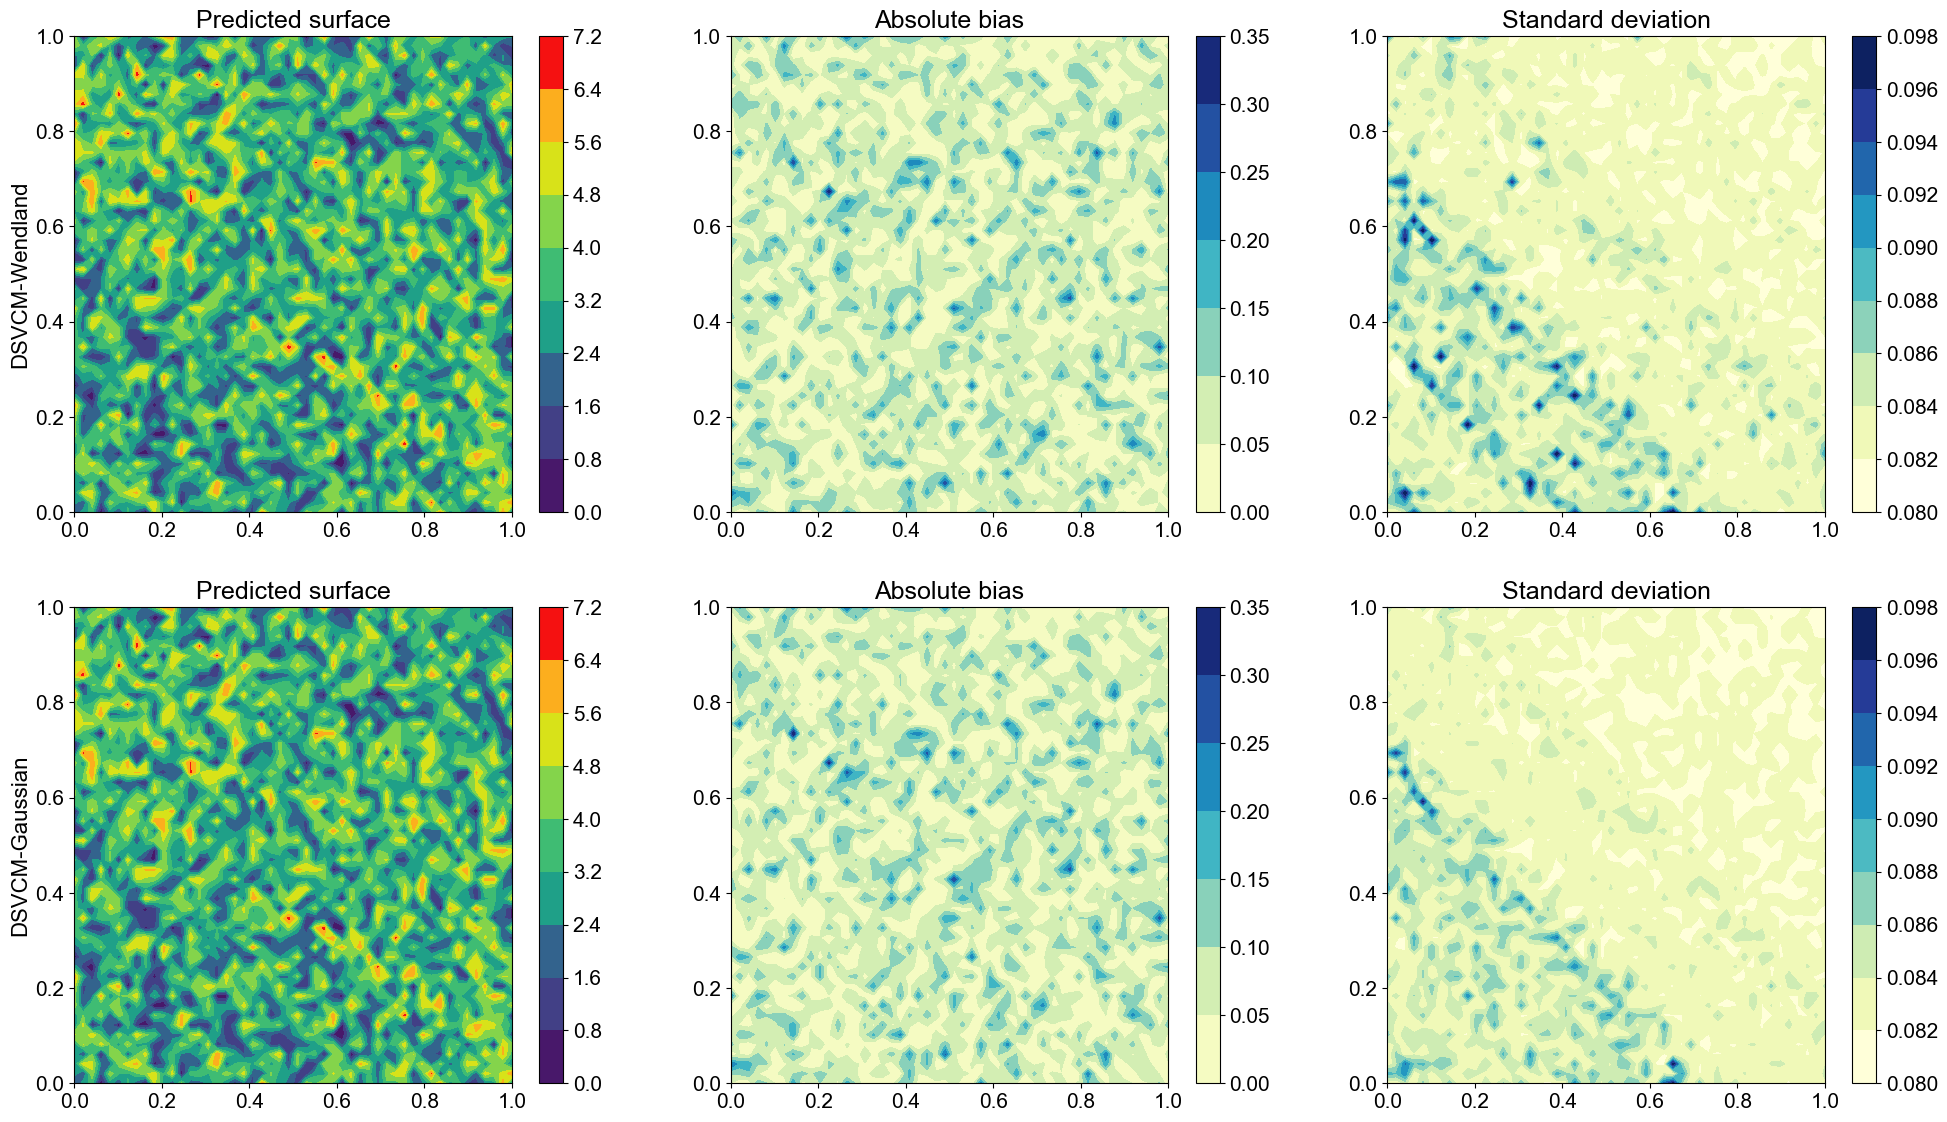

In [ ]:
config = {
    "font.family": 'sans-serif',
    "font.sans-serif": ['Arial'],
    "font.size": 15,
    "mathtext.fontset": 'stixsans',
}
plt.rcParams.update(config)



n=50
t=487
for i in range(2500):
    if Z_std_w[i]>0.098:
        Z_std_w[i]=0.098

true_map=Z[:,t].reshape(50,50).cpu()-23.1795

fig, ax = plt.subplots(2, 3, figsize=(24,13.6),gridspec_kw={'width_ratios': [1,1,1]})
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)



colors = ["#48186a", "#424086", "#33638d", "#26828e", "#1fa088", "#3fbc73", "#84d44b", "#d8e219", "#fcae1e",'#f51111']
levels = len(colors)-1
cm     = matplotlib.colors.ListedColormap(colors)



field_w=pred_data_w[:,t].detach().cpu().numpy().reshape(50,50)-23.1795
field_g=pred_data_g[:,t].detach().cpu().numpy().reshape(50,50)-23.1795
vmin = field_w.min() 
vmax = field_w.max()
contourf1=ax[0,0].contourf(x,y,field_w,levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf1)
ax[0,0].set_title('Predicted surface')
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,0].set_ylabel('DSVCM-Wendland',fontsize=16)


contourf2=ax[0,1].contourf(x,y,abs(np.array(field_w)-np.array(true_map)),cmap='YlGnBu', linestyles='None')
cbar = fig.colorbar(contourf2)
ax[0,1].set_title('Absolute bias')
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)

vmin = Z_std_g.min() 
vmax = Z_std_g.max()

contourf3=ax[0,2].contourf(x,y,Z_std_w.reshape(50,50),levels=levels, cmap='YlGnBu', linestyles='None',vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf3)
ax[0,2].set_title('Standard deviation')
ax[0,2].set_xlim(0,1)
ax[0,2].set_ylim(0,1)

vmin = field_g.min() 
vmax = field_g.max()

contourf4=ax[1,0].contourf(x,y,field_g,levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf4)
ax[1,0].set_title('Predicted surface')
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_ylabel('DSVCM-Gaussian',fontsize=16)

contourf5=ax[1,1].contourf(x,y,abs(np.array(field_g)-np.array(true_map)),cmap='YlGnBu', linestyles='None')
cbar = fig.colorbar(contourf5)
ax[1,1].set_title('Absolute bias')
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)

vmin = Z_std_g.min() 
vmax = Z_std_g.max()

contourf6=ax[1,2].contourf(x,y,Z_std_g.reshape(50,50),levels=levels, cmap='YlGnBu', linestyles='None',vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf6)
ax[1,2].set_title('Standard deviation')
ax[1,2].set_xlim(0,1)
ax[1,2].set_ylim(0,1)

# plt.savefig('simu.pdf',transparent=True,bbox_inches='tight', pad_inches =0)

(0.0, 1.0)

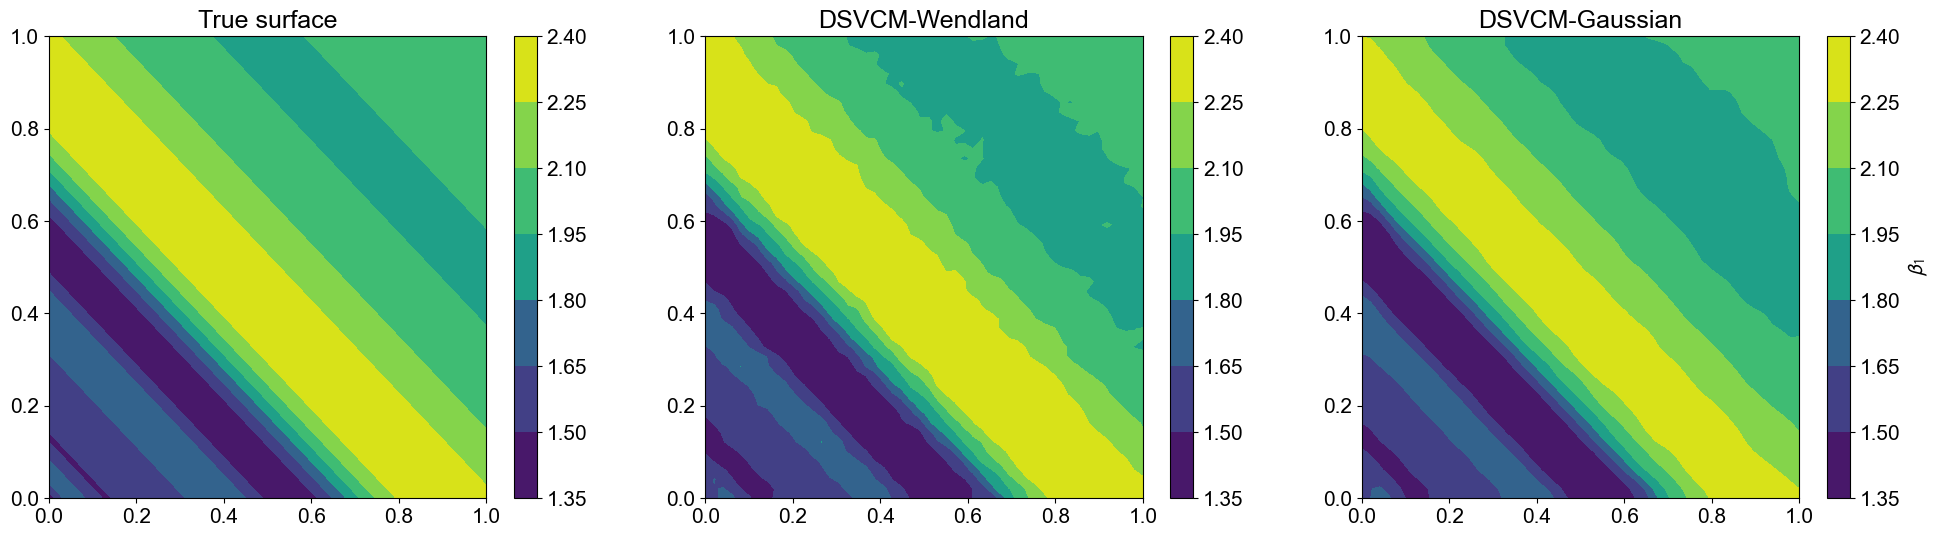

In [54]:
config = {
    "font.family": 'sans-serif',
    "font.sans-serif": ['Arial'],
    "font.size": 15,
    "mathtext.fontset": 'stixsans',
}
plt.rcParams.update(config)


fig, ax = plt.subplots(1, 3, figsize=(24,6.),gridspec_kw={'width_ratios': [1, 1,1]})
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)



colors = ["#48186a", "#424086", "#33638d", "#26828e", "#1fa088", "#3fbc73", "#84d44b", "#d8e219"]
levels = len(colors)
cm     = matplotlib.colors.ListedColormap(colors)



field=beta0_true.reshape(50,50)
vmin = field.min() 
vmax = field.max()
contourf1=ax[0].contourf(x,y,field,levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf1)
ax[0].set_title('True surface')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)


contourf2=ax[1].contourf(x,y,beta_w.reshape(50,50),levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf2)
ax[1].set_title('DSVCM-Wendland')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)

contourf3=ax[2].contourf(x,y,beta_g.reshape(50,50),levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf3,label=r'$\boldsymbol{\beta}_1$')
ax[2].set_title('DSVCM-Gaussian')
ax[2].set_xlim(0,1)
ax[2].set_ylim(0,1)

# plt.savefig('beta.pdf',transparent=True,bbox_inches='tight', pad_inches =0)